In [2]:
import os
print(os.getcwd())

import sys
sys.path.append('../Utilities/src')
from DA_tools.DA_colors2 import *


import scipy.stats as stats
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import pandas as pd


import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200


from numpy.random import normal,standard_t
from scipy.special import expit,logit
import scipy.stats as stats


/Users/jerzybaranowski/GitHub/KAIR-ISZ/bayes_book/bayes_book/notebooks




# Probabilistic computation - Markov Chain Monte Carlo



### Markov Chains

_Markov transition distribution_ is a conditional probability density function
within a given parameterization of the parameter space Q:

$$
\begin{alignat*}{6}
T :\; &Q \times Q& &\rightarrow& \; &\mathbb{R}^{+}&
\\
&(q, q')& &\mapsto& &T(q' \mid q)&.
\end{alignat*}
$$



## Example - 2 dimensional space 
$$
\begin{align*}
T(q_{1} \mid q_{0} )
&=
T(q^{1}_{1}, q^{2}_{1} \mid q^{1}_{0}, q^{2}_{0} )
\\
&=
T(q^{1}_{1} \mid q^{1}_{0}) \cdot
T(q^{2}_{1} \mid q^{2}_{0}).
\\
&=
\text{Normal}(q^{1}_{1} \mid q^{1}_{0}, \sigma) \cdot
\text{Normal}(q^{2}_{1} \mid q^{2}_{0}, \sigma).
\end{align*}
$$

In [23]:
q0 = np.array([0,0])
n_possible = 50
sigma = 1
np.random.seed(28052021)
possible_qs = normal(loc=q0,scale=np.array([sigma, sigma]),size=(n_possible,2))
q1 = possible_qs[0,:]
possible_qs_1 = normal(loc=q1,scale=np.array([sigma, sigma]),size=(n_possible,2))
q2 = possible_qs_1[1,:]


arrow_props = {'arrowstyle':'->','color':LIGHT}

def plotarrow(ax,q1,q2):
    ax.annotate(text='',xytext=q1,xy=q2,arrowprops=arrow_props)
    return ax


## Possible transitions from initial point

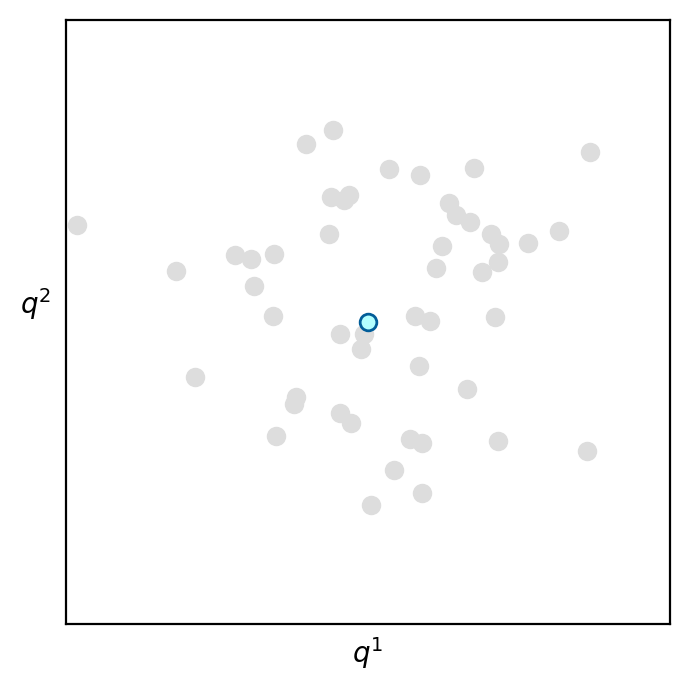

In [11]:
fig_markov_potential,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=LIGHT_GREY)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT)

ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
fig_markov_potential.savefig('../markdown/img/markov_potential_initial_transition.png')


## Realized transition from initial point

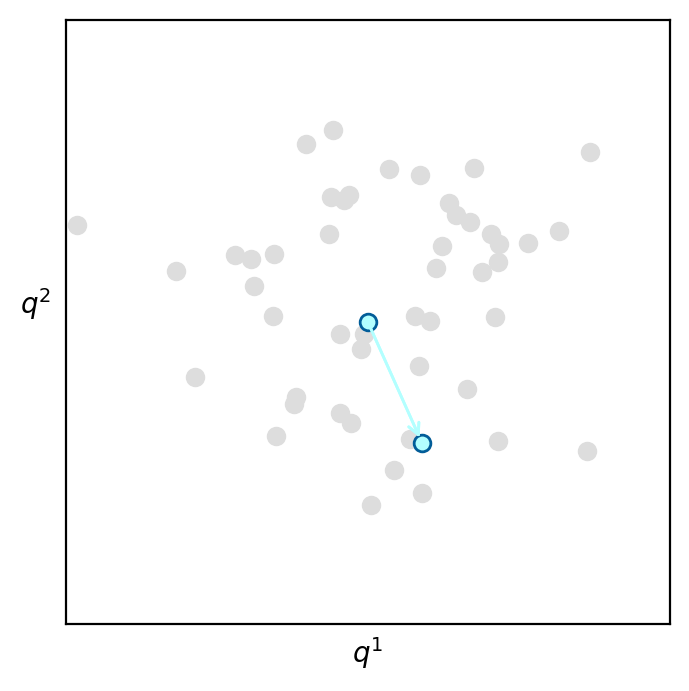

In [17]:
fig_markov_realized,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs[:,0],possible_qs[:,1],c=LIGHT_GREY)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT)
ax.scatter(q1[0],q1[1],ec=DARK,fc=LIGHT)
plotarrow(ax,q0,q1)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
plotarrow(ax,q0,q1)

fig_markov_potential.savefig('../markdown/img/markov_realized_initial_transition.png')


## Possible transitions from first transition

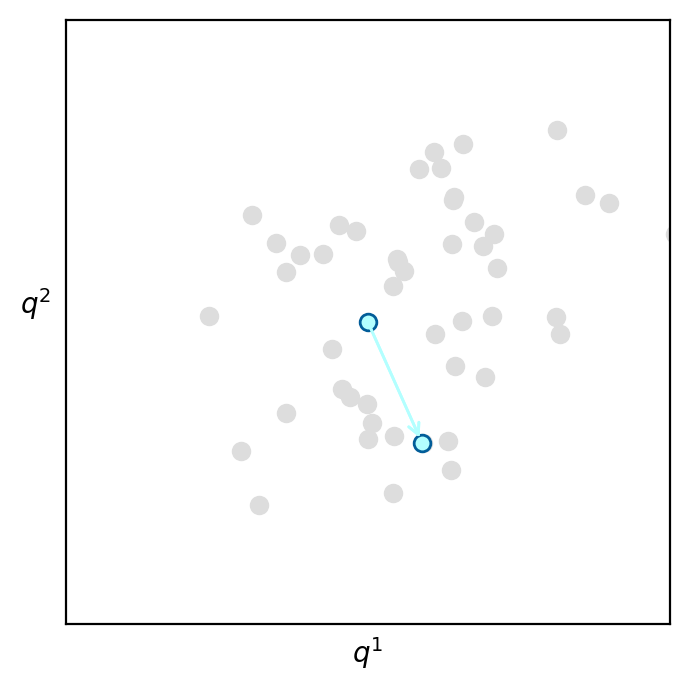

In [18]:
fig_markov_possible_second,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs_1[:,0],possible_qs[:,1],c=LIGHT_GREY)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT)
ax.scatter(q1[0],q1[1],ec=DARK,fc=LIGHT)
plotarrow(ax,q0,q1)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
plotarrow(ax,q0,q1)

fig_markov_possible_second.savefig('../markdown/img/markov_possible_second_transition.png')

In [22]:
q1

array([ 0.53676832, -1.19798932])

## Realized transition from first transition

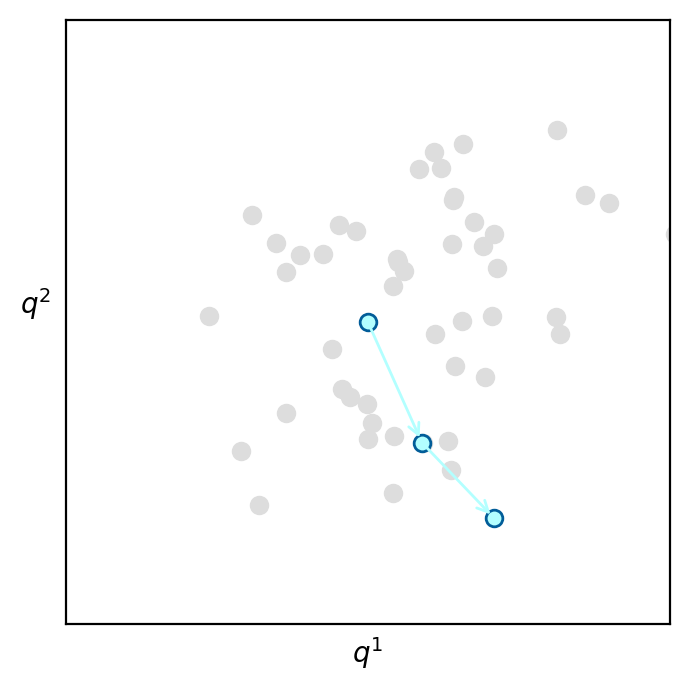

In [24]:
fig_markov_realized_second,ax = plt.subplots(1,1,figsize=(7,4))
ax.scatter(possible_qs_1[:,0],possible_qs[:,1],c=LIGHT_GREY)
ax.scatter(q0[0],q0[1],ec=DARK,fc=LIGHT)
ax.scatter(q1[0],q1[1],ec=DARK,fc=LIGHT)
ax.scatter(q2[0],q2[1],ec=DARK,fc=LIGHT)
ax.set_xlabel('$q^1$')
ax.set_ylabel('$q^2$',rotation=0)
ax.set_xlim((-3,3))
ax.set_ylim((-3,3))
ax.set_yticks([])
ax.set_xticks([])
ax.yaxis.set_label_coords(-.05, 0.5)
ax.set_aspect('equal')
plotarrow(ax,q0,q1)
plotarrow(ax,q1,q2)

fig_markov_possible_second.savefig('../markdown/img/markov_realized_second_transition.png')

## Markov Chain

_Iterating_ Markov transitions,
$$
\begin{align*}
\tilde{q}_{1} &\sim T(q_{1} \mid q_{0})
\\
\tilde{q}_{2} &\sim T(q_{2} \mid \tilde{q}_{1})
\\
\tilde{q}_{3} &\sim T(q_{3} \mid \tilde{q}_{2})
\\
\ldots
\\
\tilde{q}_{N} &\sim T(q_{N} \mid \tilde{q}_{N - 1}),
\end{align*}
$$
generates a sequence of points in the ambient space that we call a
_Markov chain_.


## Main point - stationary distribution

A probability distribution that is
preserved under Markov transitions,
$$
\pi(q) = \int \mathrm{d} q' \, \pi(q') \, T(q \mid q'),
$$
is known as the _stationary_ or _invariant_ distribution of the Markov
transition distribution.

Well-behaved Markov transition distributions admit a
unique stationary distribution, and it is within the ***stationary typical set***
that the Markov chains are most likely to wonder.

In [ ]:

bezier_curve0 = CubicBezier(start=(-15+-7j), control1=(-15+-8j), control2=(-10+1j), end=(-10+-2j))
bezier_curve1 = CubicBezier(start=(-10+-2j), control1=(-10+5j), control2=(-9+10j), end=(-4+10j))

bezier_path_mcmc = Path(bezier_curve0,bezier_curve1)

NUM_SAMPLES = 15

myPath_mcmc1 = []
for i in range(NUM_SAMPLES):
    myPath_mcmc1.append(bezier_path_mcmc.point(i/(float(NUM_SAMPLES)-1)))



In [ ]:
np.random.seed(42)
old_tuple=()
with open('../tikz/ts_mcmc_samples_1.tex', 'w') as f:
    for c in myPath_mcmc1:
        tuple = (c.real+np.random.normal(scale=0.3), c.imag+np.random.normal(scale=0.3))
        f.write(convert_to_tikz_points(tuple))
        if len(old_tuple)>0:
            arrow = '\draw[draw=light,->,shorten >=1mm,shorten <=1mm] ({0:1.2f},{1:1.2f})--({2:1.2f},{3:1.2f});\n'.format(old_tuple[0],old_tuple[1],tuple[0],tuple[1])
            f.write(arrow)
        old_tuple=tuple




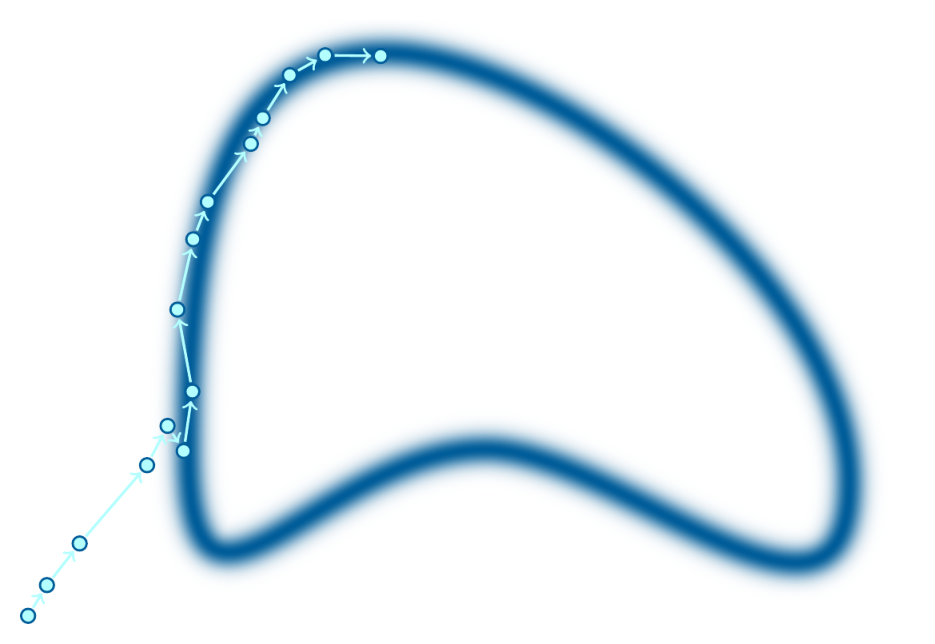

In [ ]:
input_file = 'typical_set_mcmc_samples1.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

## Markov chain converges towards typical set of distribution

<img src="img/short.png" alt="drawing" width="500"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


In [ ]:
bezier_path_mcmc = Path(bezier_curve0,bezier_curve1,bezier_curve2,bezier_curve3,bezier_curve4)

NUM_SAMPLES = 55

myPath_mcmc2 = []
for i in range(NUM_SAMPLES):
    myPath_mcmc2.append(bezier_path_mcmc.point(i/(float(NUM_SAMPLES)-1)))
myPath_mcmc2=myPath_mcmc2[:53]

In [ ]:
np.random.seed(42)
old_tuple=()
with open('../tikz/ts_mcmc_samples_2.tex', 'w') as f:
    for c in myPath_mcmc2:
        tuple = (c.real+np.random.normal(scale=0.3), c.imag+np.random.normal(scale=0.3))
        f.write(convert_to_tikz_points(tuple))
        if len(old_tuple)>0:
            arrow = '\draw[draw=light,->,shorten >=1mm,shorten <=1mm] ({0:1.2f},{1:1.2f})--({2:1.2f},{3:1.2f});\n'.format(old_tuple[0],old_tuple[1],tuple[0],tuple[1])
            f.write(arrow)
        old_tuple=tuple

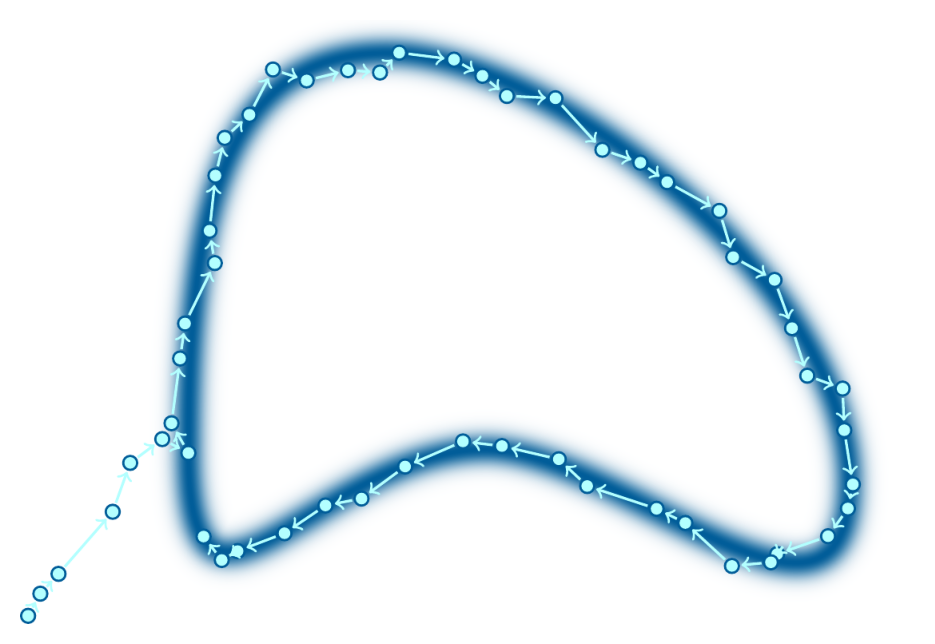

In [ ]:
input_file = 'typical_set_mcmc_samples2.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

## After reaching it it explores it

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## MCMC estimators

MCMC estimators are analogous to MC ones

$$
\hat{f}^{MCMC}_N = \frac{1}{N} \sum_{n=1}^{N}f(q_n)
$$

As long as Markov chains are _irreducible_ and _aperiodic_ they are _recurrent_, which ensures asymptotical consistency:

$$
\lim_{N\rightarrow\infty}\hat{f}^{MCMC}_N = \mathbb{E}_\pi[f]
$$

## What about finite sample behavior?

The ideal case

<img src="img/ideal/setup.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial convergence


<img src="img/ideal/convergence.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial mixing

<img src="img/ideal/initial_mixing.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Refining


<img src="img/ideal/asymptotic_mixing.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Complications with geometry

Typical set can be very irregular

In [ ]:

bezier_funnel_left_1 = CubicBezier(start=(-10+-2j), control1=(-10+5j), control2=(-4+5j), end=(-4+10j))
bezier_funnel_left_2 = CubicBezier(start=(-4+15j), control1=(1+10j), control2=(10+3j), end=(10-3j))



bezier_path = Path(bezier_funnel_left_1)

NUM_SAMPLES = 40

myPath = []
for i in range(NUM_SAMPLES):
    myPath.append(bezier_path.point(i/(float(NUM_SAMPLES)-1)))



In [ ]:
def convert_to_tikz_points(tuple):
    return '\\fill[color=dark] ({0:1.2f}, {1:1.2f}) circle (7pt);\n\\fill[color=light] ({0:1.2f}, {1:1.2f}) circle (5pt);\n'.format(tuple[0],tuple[1])


In [ ]:
np.random.seed(42)

with open('../tikz/funnel_samples_1.tex', 'w') as f:
    for c in myPath:
        tuple = (c.real+np.random.normal(scale=0.3), c.imag+np.random.normal(scale=0.3))
        f.write(convert_to_tikz_points(tuple))




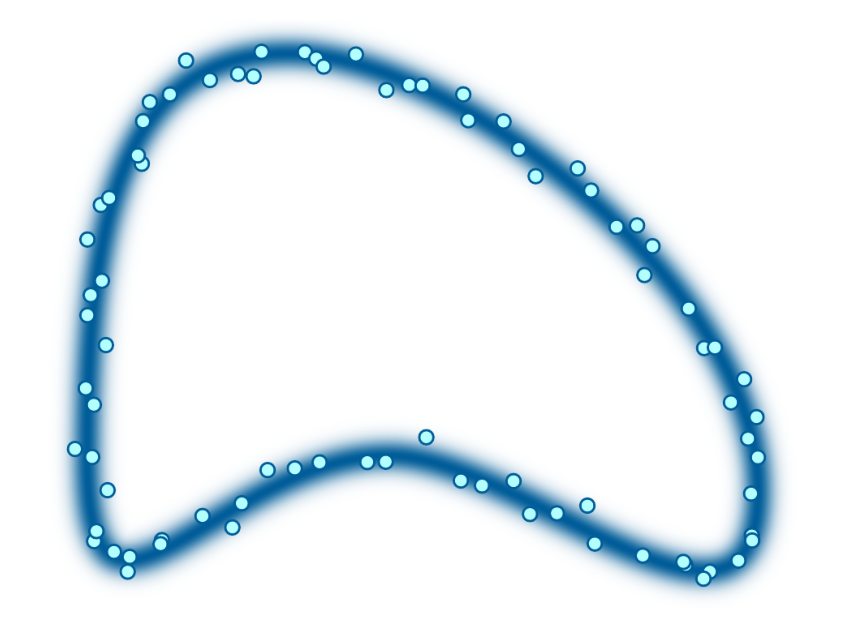

In [ ]:
input_file = 'typical_set_funnel_samples.pdf'
pic_grid = convert_from_path('../tikz/'+input_file,dpi=300)
output_folder='../markdown/img/'
output_file=input_file.replace('.pdf','.png')
pic_grid[0].save(output_folder+output_file, 'PNG')
plt.imshow(pic_grid[0])
plt.axis('off')

plt.show()

<img src="img/funnel/pinch.png" alt="drawing" width="500"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial exploration can be ok

<img src="img/funnel/initial.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Approaching difficult shapes complicates transitions


<img src="img/funnel/freeze.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Even escaping irregularities can lead to biases

<img src="img/funnel/final.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Problems with multimodality

<img src="img/multimode/setup.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## One mode can draw the Markov chain

<img src="img/multimode/initial.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Initial exploration might look as the equlibrum

<img src="img/multimode/final.png" alt="drawing" width="1000"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Markov Chain Monte Carlo Central Limit Theorem

For sufficiently long Markov chains estimator behavior is approximately Gaussian
$$
\hat{f}^{\text{MCMC}}_{N} \sim \text{normal}( \mathbb{E} [f], \text{MCMC-SE}[f] ),
$$
where the _Markov chain Monte Carlo standard error_ is defined as
$$
\begin{align*}
\text{MCMC-SE}[f]
&= \sqrt{ \frac{ \text{Var} [f] }{ \text{ESS}[f] } }
\end{align*}
$$
$\text{ESS}[f]$ is called the
_effective sample size_.

## Effective sample size

This is the measure of how the Markov chain is autocorrelated with itself. It is given by
$$
\text{ESS}[f] = \frac{N}{1 + 2 \, \sum_{l = 1}^{\infty} \rho_{l}[f]}.
$$

where $\rho_{l}$ are given by


$$
\rho_{l}[f] =
\frac{ \mathbb{E}[ ( f (q_{n + l}) - \mu_{f} ) ( f(q_{n}) - \mu_{f}) ] }
{ \mathrm{Var}_{\pi}[f] },
$$

## Practical ESS Estimator

Finite sums are good approximators, so

$$
\widehat{\mathrm{ESS}}[f] = \frac{N}{1 + 2 \sum_{l = 1}^{L} \hat{\rho}_{l}[f] }.
$$

with 

$$
\hat{\rho}_{l}[f]
=
\frac{ \frac{1}{N} \sum_{n = 0}^{N - l}
( f (q_{n + l}) - \hat{\mu}_{f} ) ( f(q_{n}) -\hat{\mu}_{f}) }
{ \widehat{\mathrm{Var}}[f] },
$$

## ESS interpretation

For independent samples all autocorrelations will vanish and
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] = 0.
$$
In this case $\text{ESS}[f] = N$ and the Markov chain Monte Carlo standard error
reduces to the Monte Carlo standard error.

Positive autocorrelations,
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] > 0,
$$
suppress the effective sample size which in turn increases the Markov chain
Monte Carlo standard error.

Negative autocorrelations,
$$
\sum_{l = 1}^{\infty} \rho_{l}[f] < 0,
$$
actually _enhance_ the effective sample size relative to the total number of
iterations which then _decreases_ the Markov chain Monte Carlo standard error
below the Monte Carlo standard error

## The Estimated Central Limit Theorem

$$
\hat{f} \sim \text{normal}( \mathbb{E} [f], \widehat{\text{MCMC-SE}}[f] ),
$$
where
$$
\widehat{\text{MCMC-SE}}[f] =
\sqrt{ \frac{ \widehat{ \text{Var}} [f] }{ \widehat{\text{ESS}} [ f ] } }
$$

## Looking for stationarity


<img src="img/traces/gauss_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Freezing is bad


<img src="img/traces/funnel_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Too short for comfort


<img src="img/traces/funnel_short_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multiple modes lead to multiple realizations


<img src="img/traces/gauss_multi_init_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multiple chains can help with detecting multimodality

<img src="img/traces/gauss_multi_chain_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multiple chains help finding problems


<img src="img/traces/funnel_multi_chain_trace.png" alt="drawing" width="800"/>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Multichain diagnostics 

***Within chain variance*** $W[f]$ the empirical average of the square of the Markov chain Monte Carlo
standard errors,
$$
\hat{W}[f] = \frac{1}{C} \sum_{c = 1}^{C} (\text{MCMC-SE}_{c}[f])^{2}
$$

***Between chain variance***, $B[f]$, the empirical variance of the
Markov chain Monte Carlo estimators themselves,
$$
\hat{B}[f] = \frac{N}{C - 1} \sum_{c = 1}^{C}
\left( \hat{f}^{\text{MCMC}}_{c, N} - \hat{\hat{f}} \right)^{2},
$$

## $\hat{R}$ - potential scale reduction factor

$$
\hat{R}[f] = \sqrt{ \frac{N - 1}{N}
+ \frac{1}{N} \frac{ \hat{B} [ f ] }{ \hat{W} [ f] } }.
$$
As the ensemble of Markov chains reach the same equilibrium $\hat{R}$ should
approach one. 





## Geweke statistic

Comparison of the Markov chain Monte Carlo estimators derived at the beginning and end of a single Markov chain

$$
G = \frac{
\hat{f}^{\text{MCMC}}_{B, N_{B}}
- \hat{f}^{\text{MCMC}}_{E, N_{E}} }
{ \sqrt{
(\text{MCMC-SE}_{B}[f])^{2} + (\text{MCMC-SE}_{E}[f])^{2}
} }.
$$

$\hat{f}^{\text{MCMC}}_{B, N_{B}}$ denotes the Markov chain Monte Carlo estimator of the function $f$ from the first $N_{B}$
points at the beginning of a Markov chain and 

$\hat{f}^{\text{MCMC}}_{E, N_{E}}$
denotes the estimator from the last $N_{E}$ points

## Split $\hat{R}$

**split potential scale reduction factor**, or split $\hat{R}[f]$, combines
the qualitative features of both diagnostics by generating an ensemble of Markov
chains and then splitting them in half before computing the $\hat{R}$ statistic.
In this way split $\hat{R}$ can capture inconsistencies both between the Markov
chains in the ensemble as well as within each Markov chain.

## Warmup

- Theoretically - after initialization
- Adaptively - use the information from chain to detect
- Heuristically - drop fixed number of iterations

## Metropolis-Hastings algorithm - generating MC with desired stationary distribution $\pi(q)$

1. Let $K(q \mid q')$ be a _proposal distribution_ - we wil generate possible transition from it
2. _Metropolis-Hastings acceptance probability_ between an initial point, $q$,
and a proposal, $q'$:
$$
a(q', q) = \min \left(1,
\frac{ K(q \mid q') \, \pi(q') }{ K(q' \mid q) \, \pi(q) } \right).
$$
3. We can then define a Metropolis transition as a mixture of jumping to the proposal with probability $a(q', q)$ and staying at the initial point with probability $1 - a(q', q)$.


Often proposal distribution is normal - for example _random walk Metropolis_

$$
K(q' \mid q, \Sigma) = \text{normal}(q' \mid q, \Sigma).
$$

In [ ]:
target_lpdf = lambda q:   - 0.5 * ( (q[0] - 1)**2 + (q[1] + 1)**2 ) - 0.5 * 2 * np.log(6.283185307179586)


In [ ]:
q_1=np.linspace(-2,4,600)
q_2=np.linspace(-4,2,600)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(600):
    for j in range(600):
        Z[i,j]=np.exp(target_lpdf((Q1[i,j],Q2[i,j])))


NameError: name 'matplotlib' is not defined

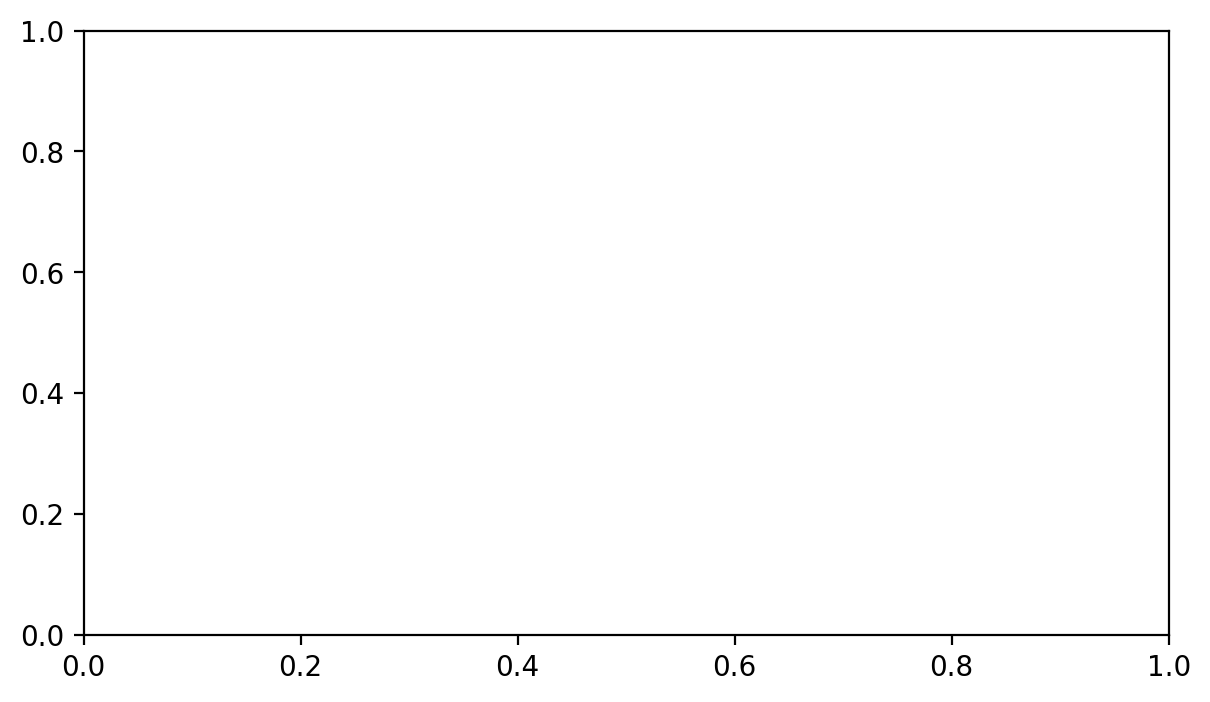

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.contour(Q1,Q2,Z,levels=25,colors=matplotlib.colors.to_hex(dark))

In [ ]:
n_transitions = 5000
D = 2 
sigma = 1.4
mcmc_samples = np.zeros((n_transitions+1,D+1))

In [ ]:
np.random.seed(25032021)
mcmc_samples[0, 0:D] = np.random.normal(0, 3,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf(qp) - target_lpdf(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [ ]:
def mc_stats(mcmc_samples, warmup_iters=0, variable_names=[]):
    col_names = ['mean','standard deviation', 'mcmc_se', 'ESS', 'split_Rhat']
    df = pd.DataFrame(columns=col_names)
    m,n = mcmc_samples.shape
    if len(variable_names)==0:
        variable_names = ['var_'+str(x+1) for x in range(n-1)]
        variable_names.append('acceptance probability')
    if len(variable_names)==n-1:
        variable_names.append('acceptance probability')
    for i in range(n):
        data=np.zeros(5)
        var_i = mcmc_samples[warmup_iters+1:,i]
        data[0] = np.mean(var_i)
        data[1] = np.std(var_i)
        data[2] = az.mcse(var_i)
        data[4] = az.rhat(np.array(np.split(var_i,2)))
        data[3] = np.round(az.ess(var_i))
        df.loc[variable_names[i]] = data
    return df




In [ ]:
mc_stats(mcmc_samples,warmup_iters=100)

,mean,standard deviation,mcmc_se,ESS,split_Rhat
var_1,0.956629,1.004160,0.039765,631.0,1.001759
var_2,-0.994352,0.984925,0.038213,677.0,1.003114
acceptance probability,0.423585,0.394535,0.005515,5061.0,1.000370


In [ ]:
mc_series = pd.DataFrame(mcmc_samples[100:,:2],columns=['var_1','var_2'])
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.var_1.expanding().mean()
expan_std_1 = mc_series.var_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.var_2.expanding().mean()
expan_std_2 = mc_series.var_2.expanding().apply(series_mcse)



arviz - WARNING - Shape validation failed: input_shape: (1, 1), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 2), minimum_shape: (chains=1, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 3), minimum_shape: (chains=1, draws=4)


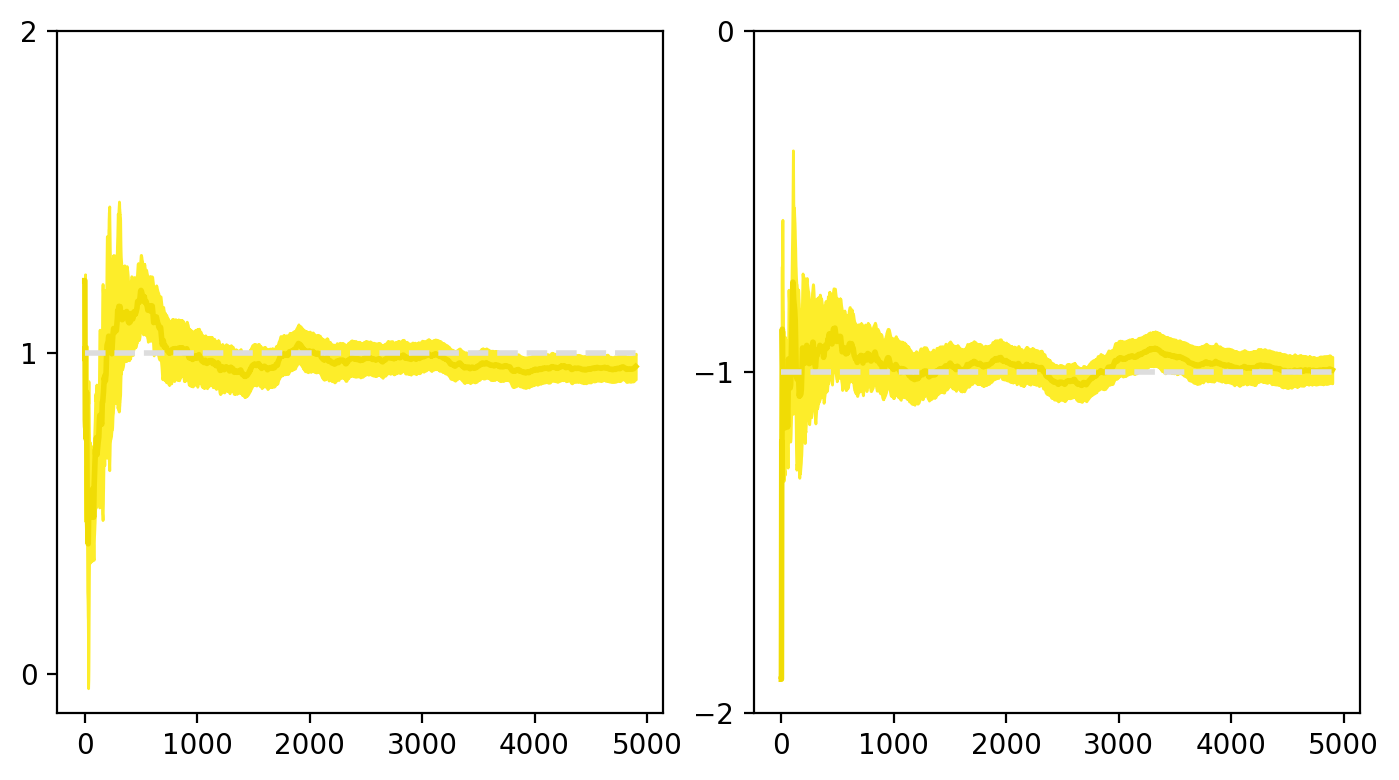

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=MID_HIGHLIGHT,linewidth=2)
ax1.plot([0,N],[1,1],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=MID)

ax2.plot(expan_mean_2,color=MID_HIGHLIGHT,linewidth=2)
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=MID)
ax2.plot([0,N],[-1,-1],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

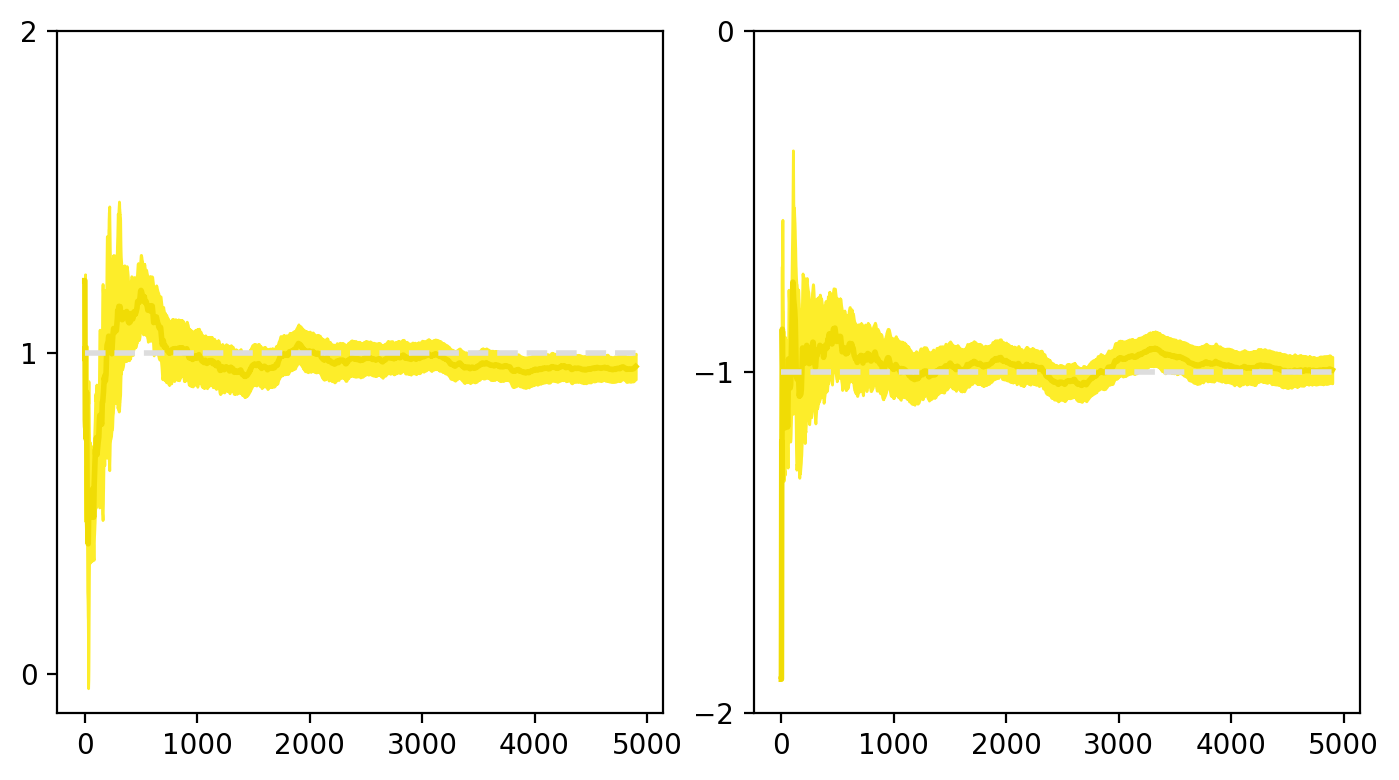

In [ ]:
fig

In [ ]:
res = np.array(np.split(mcmc_samples[101:,1],2))

In [ ]:
az.rhat(res)

1.0031135258368309

In [ ]:
np.mean(mcmc_samples[101:,0])

0.9566294769584612

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

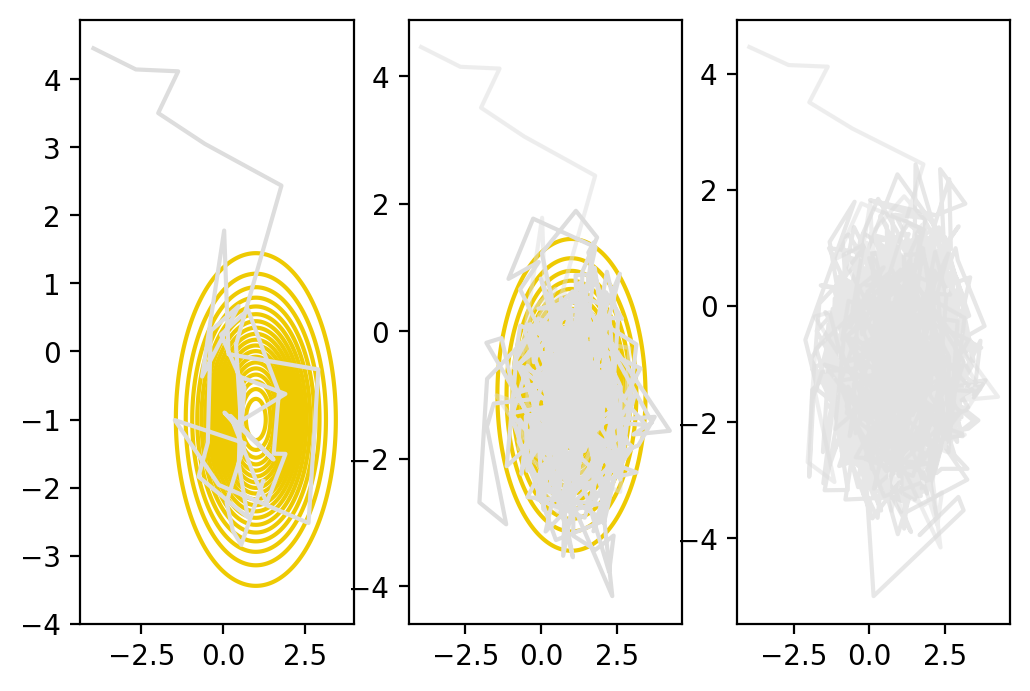

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax1.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],color=LIGHT_GREY)
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax2.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],alpha=0.5,color=LIGHT_GREY)
ax2.plot(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],alpha=1,color=LIGHT_GREY)
ax3.plot(mcmc_samples[:1001,0],mcmc_samples[:1001,1],alpha=0.5,color=LIGHT_GREY)
ax3.plot(mcmc_samples[1001:,0],mcmc_samples[1001:,1],alpha=.7,color=LIGHT_GREY)
plt.tight_layout

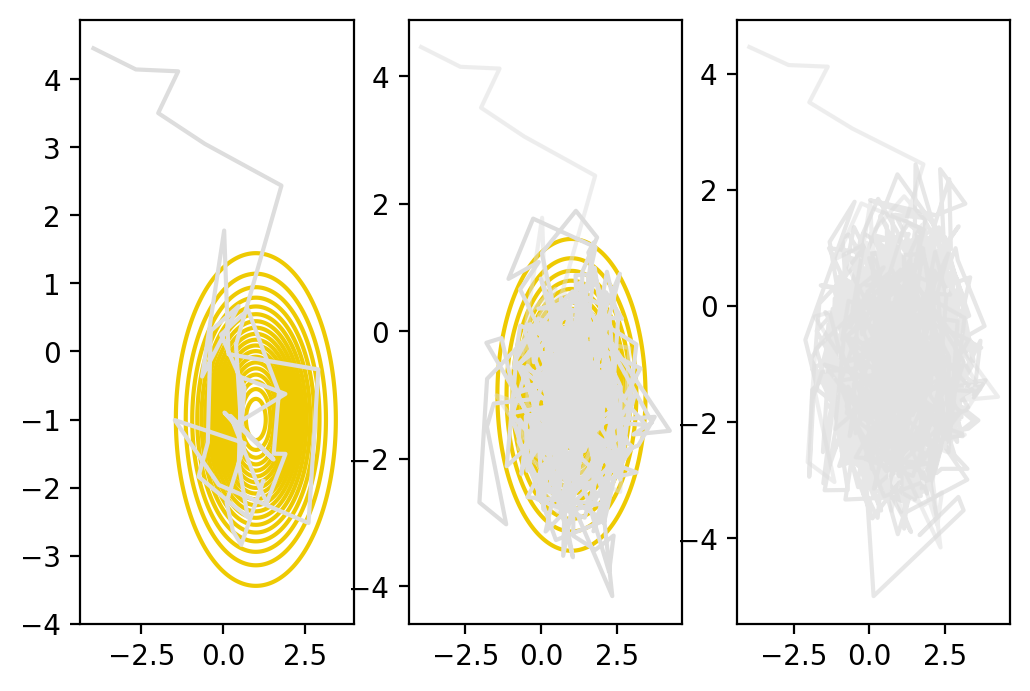

In [ ]:
fig

<AxesSubplot:>

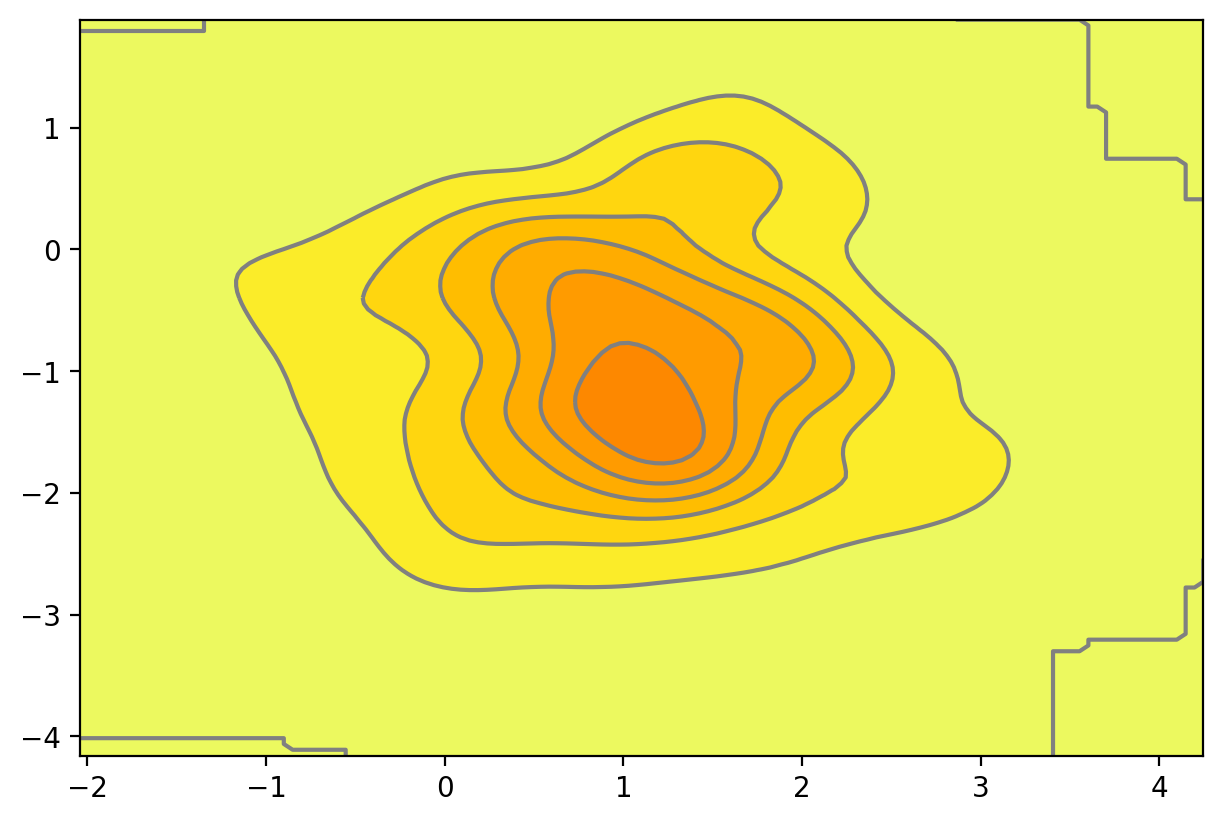

In [ ]:
az.plot_dist(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],contourf_kwargs={'cmap':plt.cm.Wistia})

In [ ]:
def target_lpdf2(q):
    D = len(q)
    lpdf = - 0.5 * q[0]**2 - 0.5 * np.log(6.283185307179586)
    lpdf = lpdf - 0.5 * (q[1] / 5)**2 - 0.5 * np.log(6.283185307179586 * 25)
    for d in range(2,D):
        lpdf = lpdf - 0.5 * ((q[d] - q[0]) / np.exp(q[1]))**2
        lpdf = lpdf - 0.5 * np.log(6.283185307179586) - q[1]
    return lpdf

In [ ]:
q_2=np.linspace(-10,2,1000)
q_3=np.linspace(-11,11,1000)
Q2,Q3 = np.meshgrid(q_2,q_3)
Z = np.zeros(Q2.shape)
for i in range(1000):
    for j in range(1000):
        q=[0, q_2[j],q_3[i], 0, 0, 0, 0, 0, 0, 0, 0, 0]
        Z[i,j]=np.exp(target_lpdf2(q))

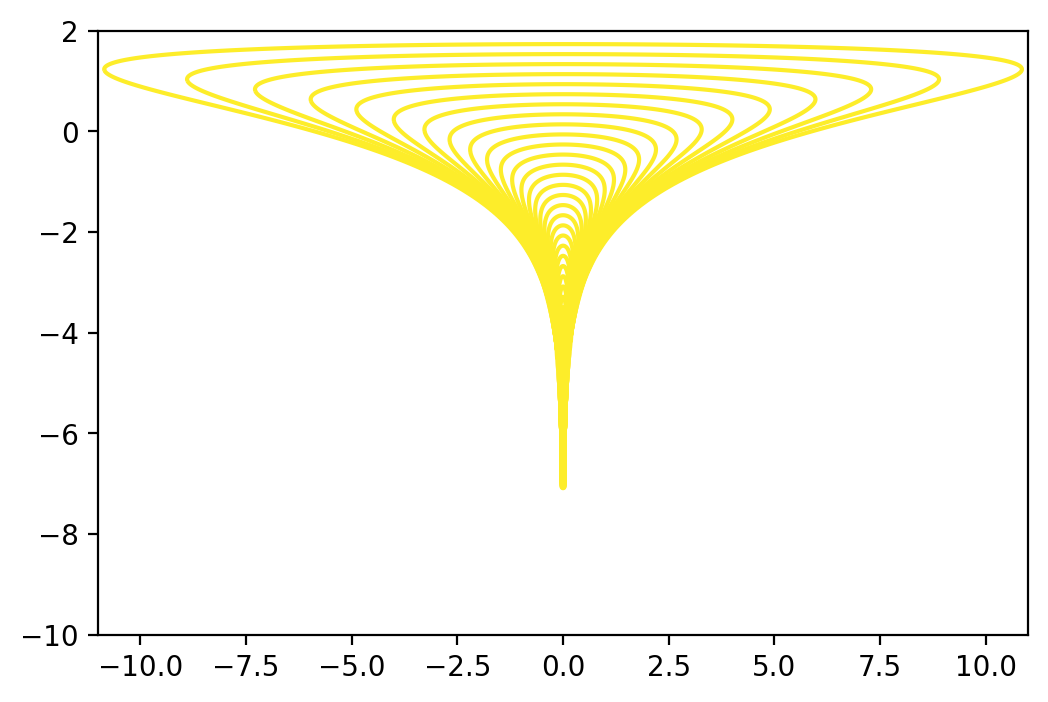

In [ ]:
fig,ax = plt.subplots(1,1)
ax.contour(Q3,Q2,Z,levels=np.exp([*range(-30,90,2)]),colors=MID)

In [ ]:
np.random.seed(25032021)
n_transitions = 5000
sigma = 0.5
D = 12
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 3,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf2(qp) - target_lpdf2(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

<AxesSubplot:>

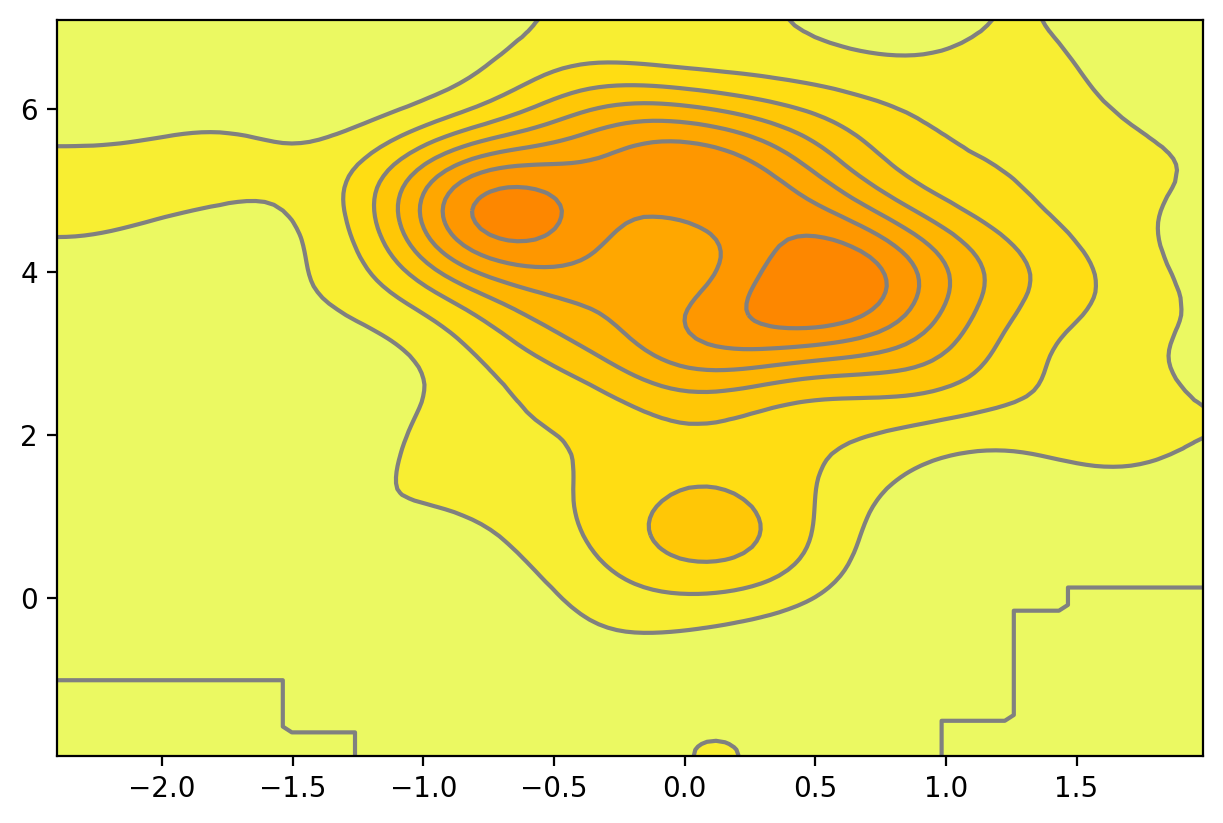

In [ ]:
az.plot_dist(mcmc_samples[101:1001,0],mcmc_samples[101:1001,2],contourf_kwargs={'cmap':plt.cm.Wistia})

In [ ]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

,mean,standard deviation,mcmc_se,ESS,split_Rhat
mu,0.312808,0.817080,0.100772,67.0,1.054961
log tau,1.059258,0.534453,0.316767,3.0,1.456163
acceptance probability,0.352628,0.383232,0.015018,434.0,1.012255


In [ ]:
mc_series = pd.DataFrame(mcmc_samples[100:,:2],columns=['var_1','var_2'])
N=len(mc_series)
series_mcse = lambda series: az.mcse(series.values)
expan_mean_1 = mc_series.var_1.expanding().mean()
expan_std_1 = mc_series.var_1.expanding().apply(series_mcse)
expan_mean_2 = mc_series.var_2.expanding().mean()
expan_std_2 = mc_series.var_2.expanding().apply(series_mcse)

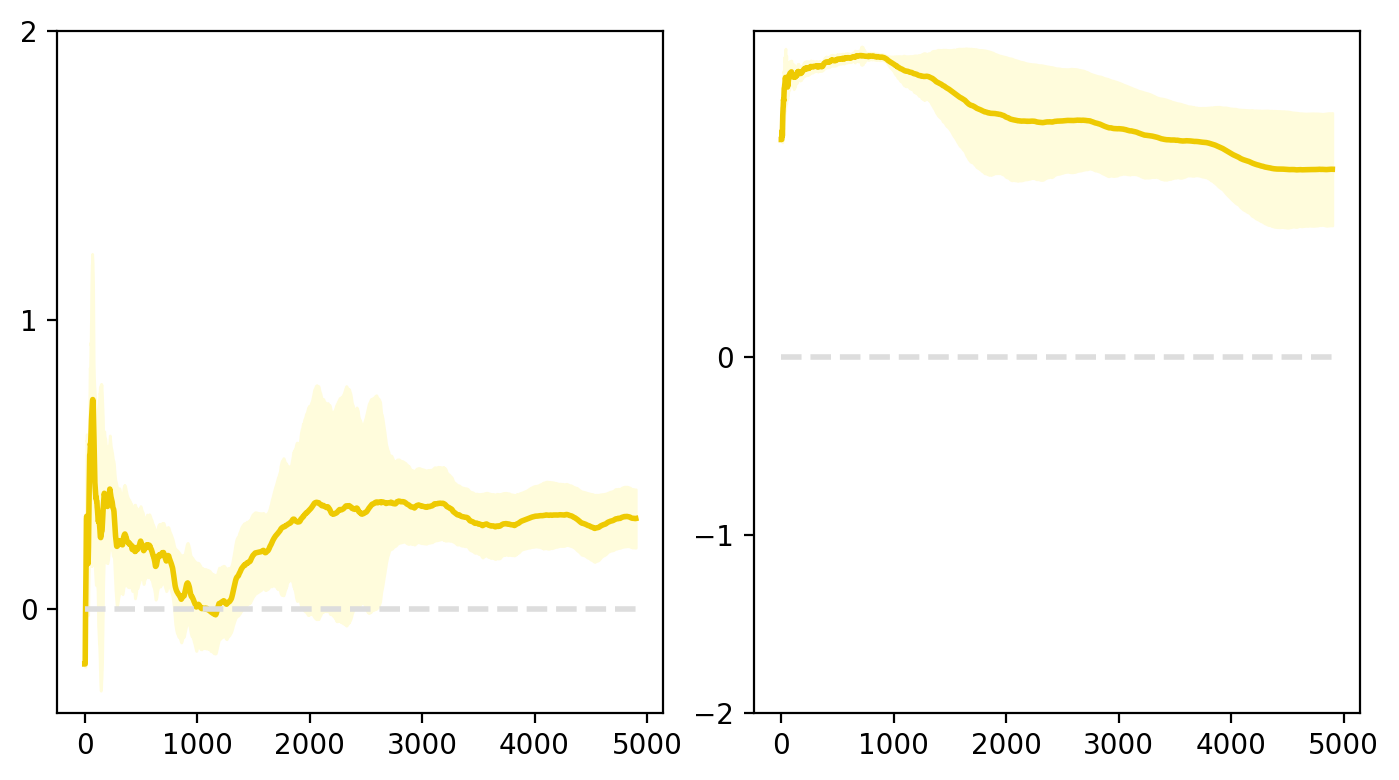

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(expan_mean_1,color=DARK,linewidth=2)
ax1.plot([0,N],[0,0],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.fill_between([*range(N)],expan_mean_1-expan_std_1,expan_mean_1+expan_std_1,color=LIGHT)

ax2.plot(expan_mean_2,color=DARK,linewidth=2)
ax2.fill_between([*range(N)],expan_mean_2-expan_std_2,expan_mean_2+expan_std_2,color=LIGHT)
ax2.plot([0,N],[0,0],color=LIGHT_GREY,linestyle = '--',linewidth=2)

ax1.set_yticks([0,1,2])
ax2.set_yticks([-2,-1,0])

plt.tight_layout()

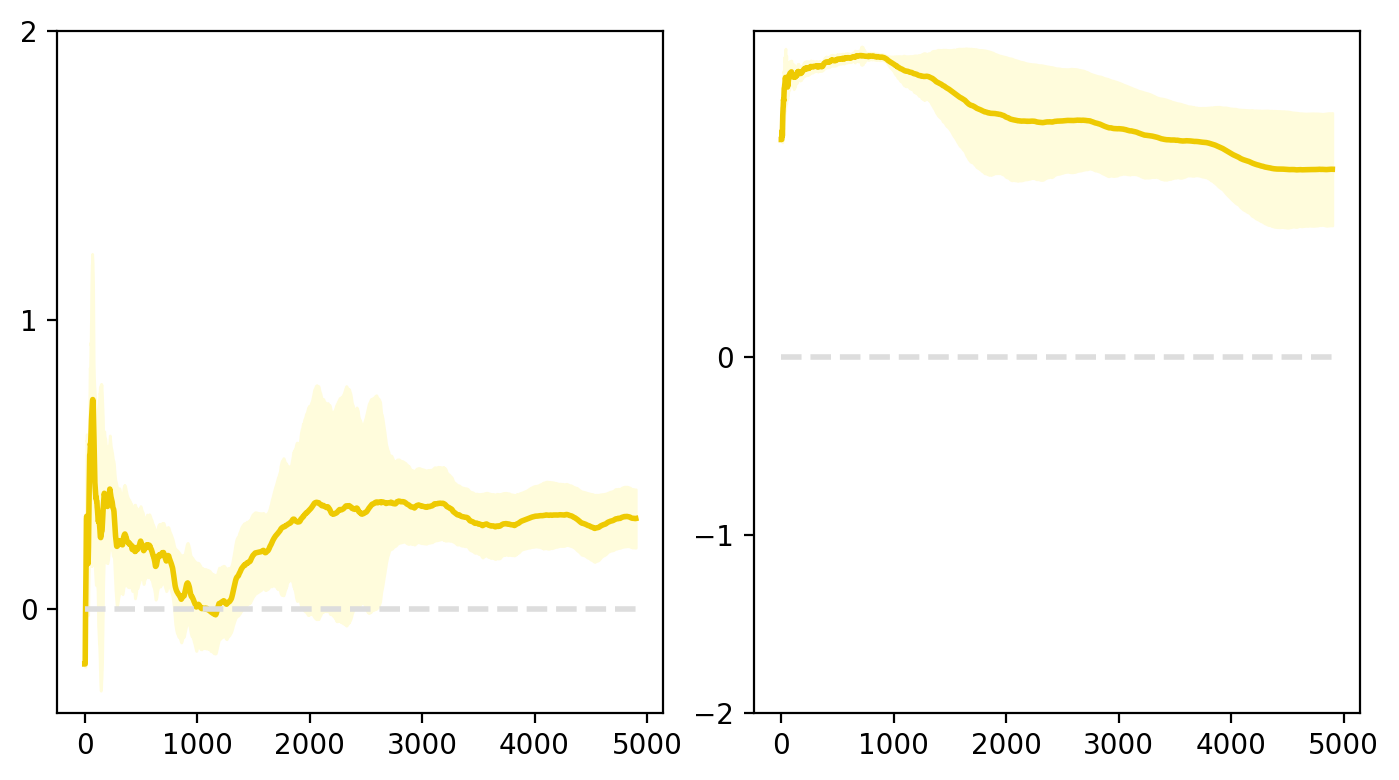

In [ ]:
fig

In [ ]:
np.random.seed(25032021)
n_transitions = int(1e5)
sigma = 0.5
D = 12
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 3,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf2(qp) - target_lpdf2(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

mc_stats(mcmc_samples,warmup_iters=100)

,mean,standard deviation,mcmc_se,ESS,split_Rhat
var_1,-0.017098,0.998269,0.128760,60.0,1.046512
var_2,0.170759,0.930362,0.160952,36.0,1.044230
var_3,0.199463,2.282232,0.200693,123.0,1.043242
var_4,0.014156,2.387506,0.197773,127.0,1.025883
var_5,-0.163802,2.397738,0.202534,132.0,1.018624
var_6,-0.047085,2.366912,0.160519,201.0,1.023556
var_7,0.317387,2.598201,0.271139,93.0,1.028625
var_8,-0.202578,2.710389,0.248519,102.0,1.031154
var_9,-0.146753,2.758791,0.345525,66.0,1.044462
var_10,-0.067363,2.220370,0.186956,127.0,1.043958


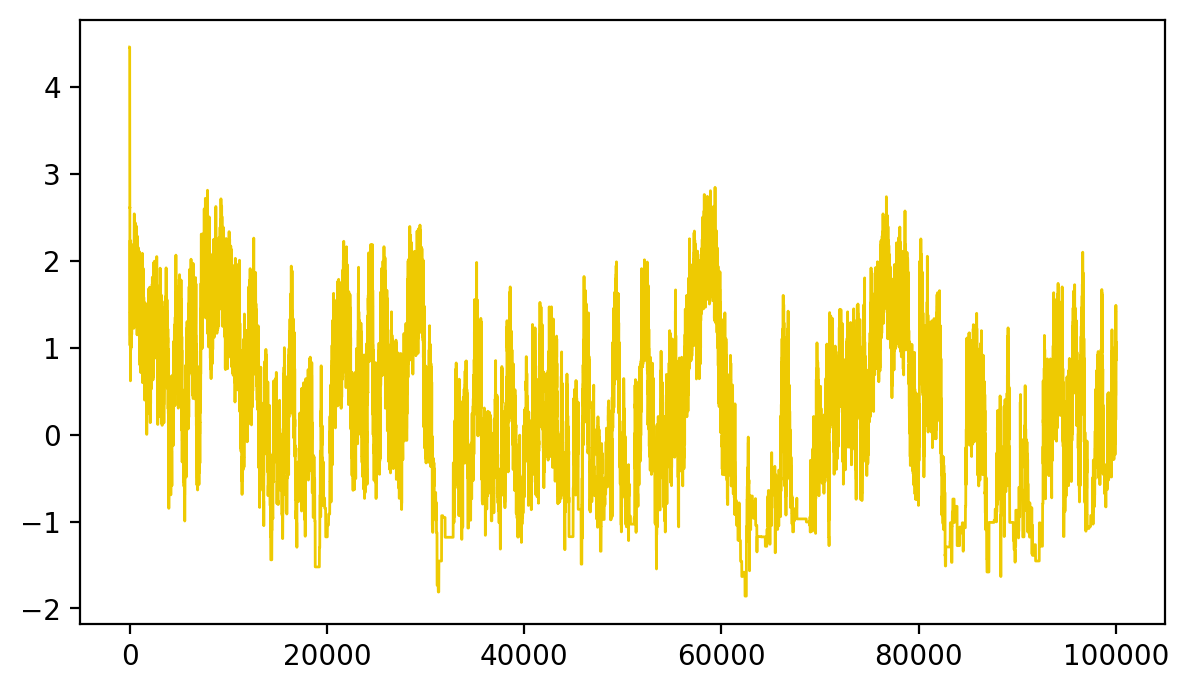

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize = (7,4))

ax1.plot(mcmc_samples[:,1],color=DARK,linewidth=1)

In [ ]:
D = 2

def target_lpdf_c1(q):
  mu1 = 4
  sigma1 = 1

  mu2 = 8
  sigma2 = 2

  lpdf = -0.5 * ( ((q[0] - mu1) / sigma1)**2 + ((q[1] - mu2) / sigma2)**2 )
  lpdf = lpdf - 0.5 * np.log(6.283185307179586) - np.log(sigma1) - np.log(sigma2)
  return lpdf 

def target_lpdf_c2(q):
  mu1 = -8
  sigma1 = 2

  mu2 = -4
  sigma2 = 1

  lpdf = -0.5 * ( ((q[0] - mu1) / sigma1)**2 + ((q[1] - mu2) / sigma2)**2 )
  lpdf = lpdf - 0.5 * np.log(6.283185307179586) - np.log(sigma1) - np.log(sigma2)
  return lpdf



def target_lpdf3(x):
  lpdf1 = np.log(0.5) + target_lpdf_c1(x)
  lpdf2 = np.log(0.5) + target_lpdf_c2(x)
  if lpdf1 > lpdf2:
      lpdf = lpdf1 + np.log(1 + np.exp(lpdf2 - lpdf1))
  else:
      lpdf = lpdf2 + np.log(1 + np.exp(lpdf1 - lpdf2))
  return lpdf


In [ ]:
q_1=np.linspace(-13,7,200)
q_2=np.linspace(-7,13,200)
Q1,Q2 = np.meshgrid(q_1,q_2)
Z = np.zeros(Q1.shape)
for i in range(200):
    for j in range(200):
        Z[i,j]=np.exp(target_lpdf3((Q1[i,j],Q2[i,j])))

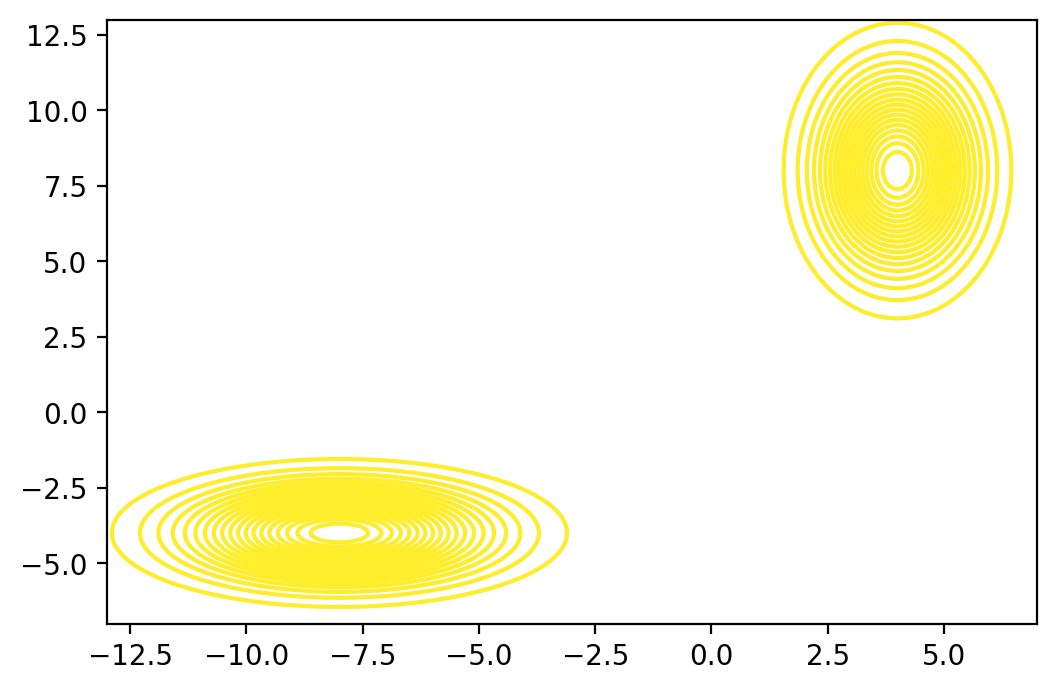

In [ ]:
fig,ax = plt.subplots(1,1)
ax.contour(Q1,Q2,Z,levels=20,colors=MID)


In [ ]:
np.random.seed(25032021)
n_transitions = 5000
sigma = 2
D = 2
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 5,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf3(qp) - target_lpdf3(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [ ]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

,mean,standard deviation,mcmc_se,ESS,split_Rhat
mu,3.940946,1.006392,0.035944,788.0,1.002237
log tau,7.995697,2.040972,0.106708,377.0,1.006069
acceptance probability,0.401185,0.396552,0.005485,5253.0,0.999711


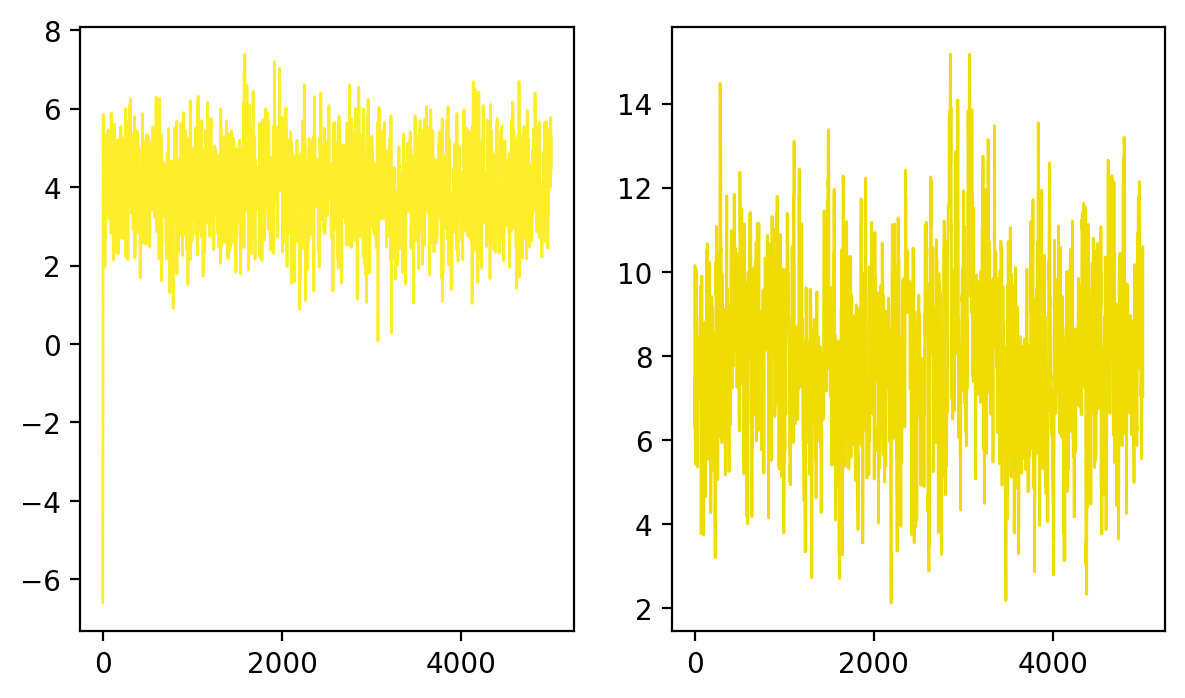

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))
ax1.plot(mcmc_samples[:,0],color=MID,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=MID_HIGHLIGHT,linewidth=1)
plt.show()

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

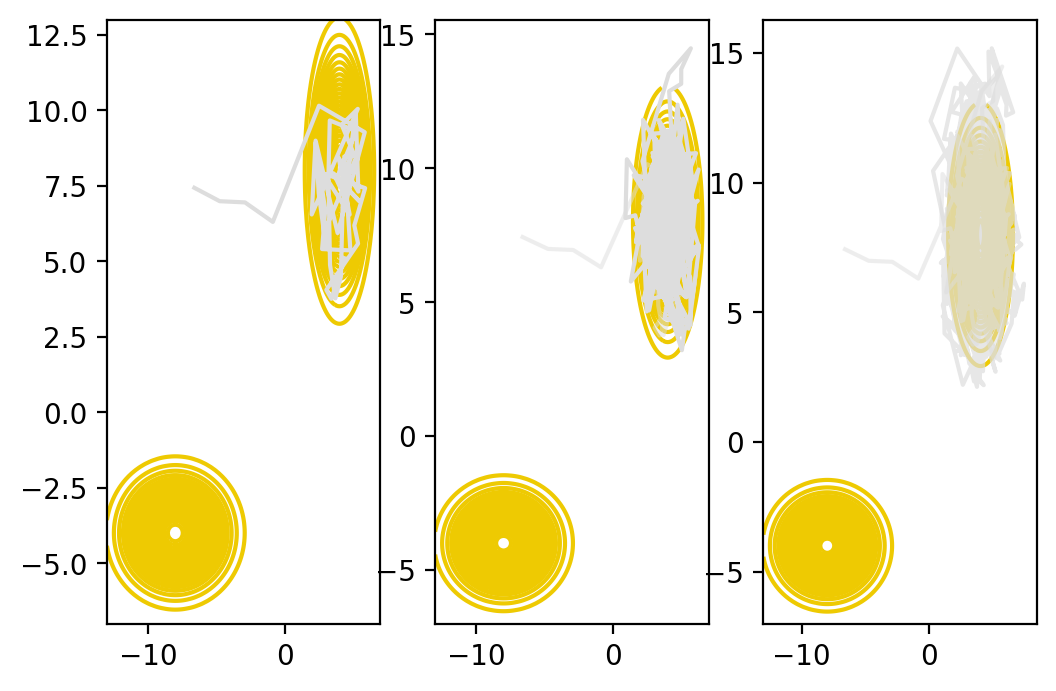

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax1.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],color=LIGHT_GREY)
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax2.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],alpha=0.5,color=LIGHT_GREY)
ax2.plot(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],alpha=1,color=LIGHT_GREY)
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK)

ax3.plot(mcmc_samples[:1001,0],mcmc_samples[:1001,1],alpha=0.5,color=LIGHT_GREY)
ax3.plot(mcmc_samples[1001:,0],mcmc_samples[1001:,1],alpha=.7,color=LIGHT_GREY)
plt.tight_layout

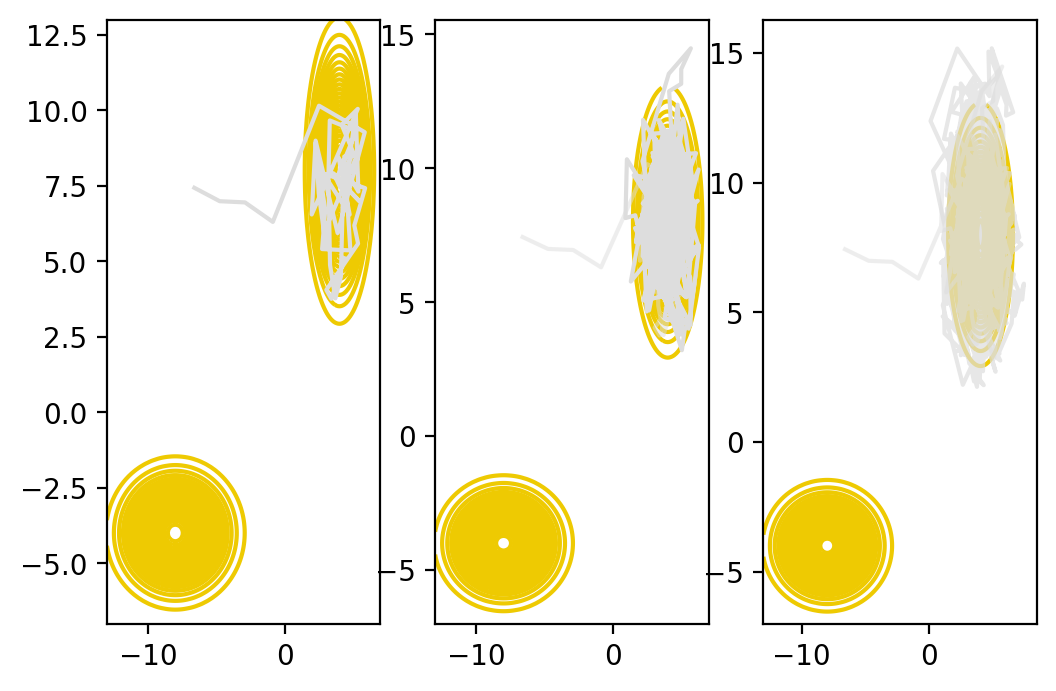

In [ ]:
fig

In [ ]:
np.random.seed(25032021)
n_transitions = 200000
sigma = 2
D = 2
mcmc_samples = np.zeros((n_transitions+1,D+1))
mcmc_samples[0, 0:D] = np.random.normal(0, 5,D)
mcmc_samples[0, D ] = 1

for n in range(n_transitions):
  q0 = mcmc_samples[n, 0:D] # Initial point
  qp = np.random.normal(q0, sigma,D)  # Proposal

  # Compute acceptance probability
  accept_prob = np.min([1., np.exp(target_lpdf3(qp) - target_lpdf3(q0))])
  mcmc_samples[n, D] = accept_prob

  # Apply Metropolis correction
  u = np.random.uniform()
  if accept_prob > u:
    mcmc_samples[n + 1, 0:D] = qp
  else:
    mcmc_samples[n + 1, 0:D] = q0

In [ ]:
mc_stats(mcmc_samples[:,[0,1,-1]],warmup_iters=100,variable_names=["mu", "log tau"])

,mean,standard deviation,mcmc_se,ESS,split_Rhat
mu,-2.120862,6.186773,6.007144,1.0,1.756584
log tau,1.866986,6.201349,6.023171,1.0,1.753685
acceptance probability,0.402297,0.395430,0.000865,205525.0,1.000006


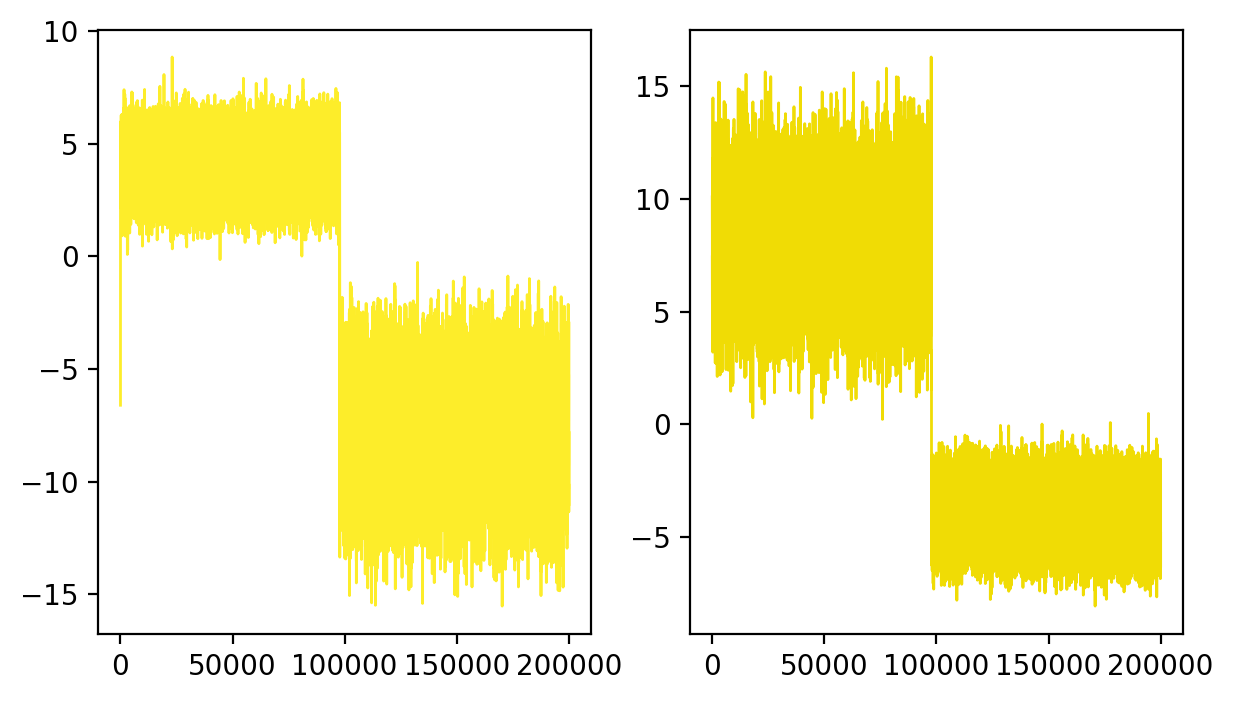

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,4))

ax1.plot(mcmc_samples[:,0],color=MID,linewidth=1)
ax2.plot(mcmc_samples[:,1],color=MID_HIGHLIGHT,linewidth=1)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

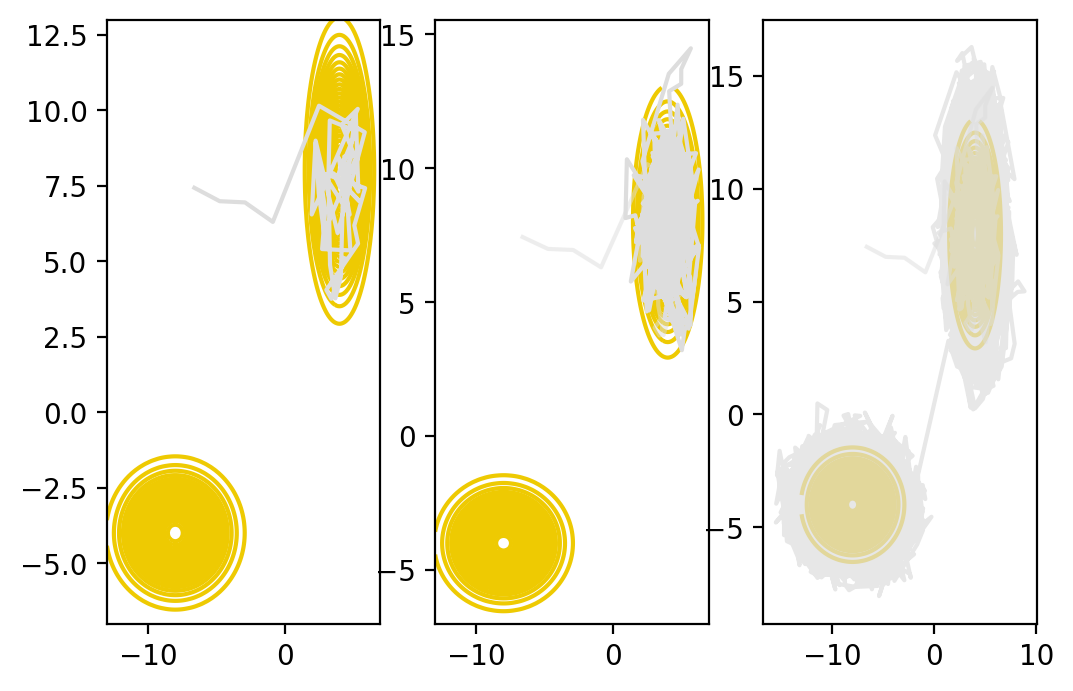

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax1.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],color=LIGHT_GREY)
ax2.contour(Q1,Q2,Z,levels=25,colors=DARK)
ax2.plot(mcmc_samples[:101,0],mcmc_samples[:101,1],alpha=0.5,color=LIGHT_GREY)
ax2.plot(mcmc_samples[101:1001,0],mcmc_samples[101:1001,1],alpha=1,color=LIGHT_GREY)
ax3.contour(Q1,Q2,Z,levels=25,colors=DARK)

ax3.plot(mcmc_samples[:1001,0],mcmc_samples[:1001,1],alpha=0.5,color=LIGHT_GREY)
ax3.plot(mcmc_samples[1001:,0],mcmc_samples[1001:,1],alpha=.7,color=LIGHT_GREY)
plt.tight_layout

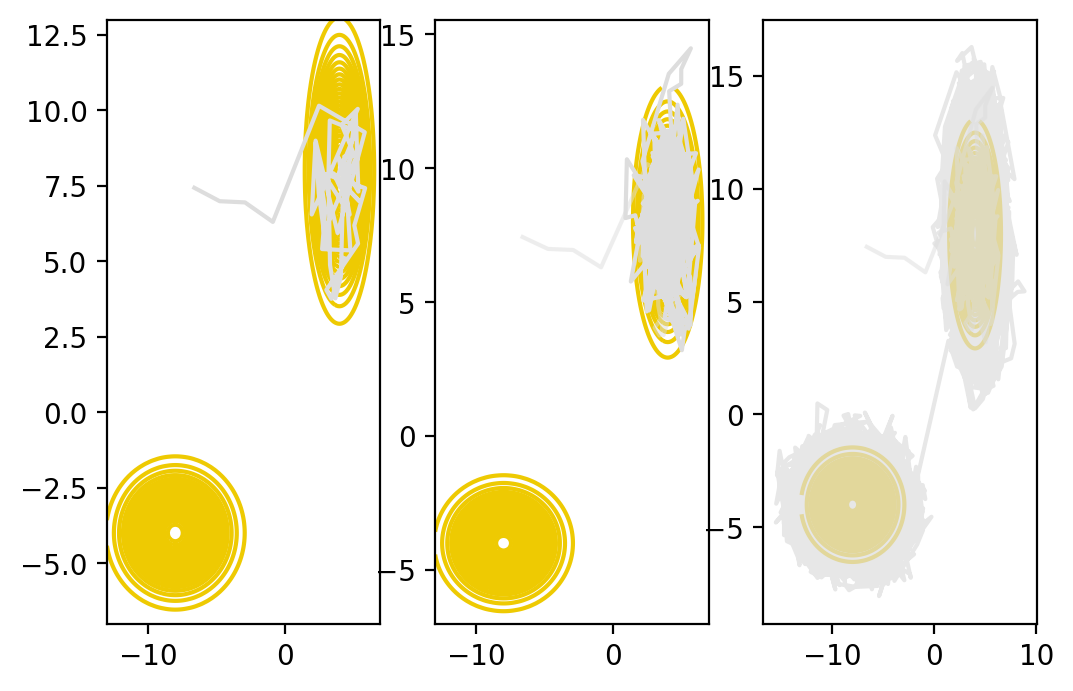

In [ ]:
fig

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


## Variational approximation

- The main idea is to approximate the posterior with functions, that can be easily sampled from (or their combination). 

- Such approximation is realized by minimization of a function called divergence, which measures how differetnt candidate and probability distribution are from one another.

- In practice it is done by minimizing certain bound on the divergence.

## Multimodality of variational approximation

It can happen, that significantly different candidates have similar divergences, that causes optimization problem to be multimodal



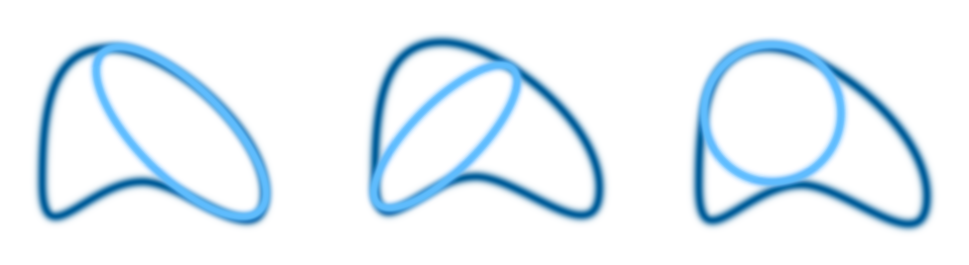

In [ ]:
fig,ax = plt.subplots(1,3)
for k in range(3):
    input_file = 'typical_set_with_bad_elipse_{}.pdf'.format(k+1)
    pic_grid = convert_from_path('../tikz/'+input_file,dpi=300,use_pdftocairo=True) 
    output_folder='../markdown/img/'
    output_file=input_file.replace('.pdf','.png')
    pic_grid[0].save(output_folder+output_file, 'PNG')
    ax[k].imshow(pic_grid[0])
    ax[k].set_axis_off()
plt.show()

<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>


<div style="text-align: right"> <span style="font-size:.3em;">Image &copy; <a href="https://betanalpha.github.io"> Michael Betancourt</a></span> </div>
